## Load Dataset

In [6]:
import networkx as nx
import os
RANDOM_STATE = 5664
def load_network(edge_list_file):
    """
    Load a network from an edge list file.
    
    Args:
        edge_list_file (str): Path to the edge list file
        
    Returns:
        networkx.Graph: The loaded network graph
    """
    try:
        # Check if file exists and has content
        if not os.path.exists(edge_list_file) or os.path.getsize(edge_list_file) == 0:
            raise FileNotFoundError(f"Edge list file not found or empty: {edge_list_file}")
        
        # Load the network
        G = nx.read_edgelist(edge_list_file)
        print(f"Network loaded from {edge_list_file}")
        print(f"  Number of nodes: {G.number_of_nodes()}")
        print(f"  Number of edges: {G.number_of_edges()}")
        print(f"\tNetwork density: {nx.density(G):.4f}")      
        
        return G
    
    except Exception as e:
        print(f"Error in load_network: {str(e)}")
        raise

# Load the network
edge_list_file_vec = "network_similarity_vec.csv"
G = load_network(edge_list_file_vec)

Network loaded from network_similarity_vec.csv
  Number of nodes: 8630
  Number of edges: 647783
	Network density: 0.0174


## Degree Distribution Analysis

In [7]:
import numpy as np
# Small world and heavy-tail analysis

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
print("Basic degree statistics:")
print(f"\tTotal degree: {sum(degree_sequence)}")
print(f"\tMinimum degree: {np.min(degree_sequence)}")
print(f"\tMaximum degree: {np.max(degree_sequence)}")
print(f"\tMean degree: {np.mean(degree_sequence):.2f}")
print(f"\tMedian degree: {np.median(degree_sequence)}")

Basic degree statistics:
	Total degree: 1295566
	Minimum degree: 1
	Maximum degree: 562
	Mean degree: 150.12
	Median degree: 118.0


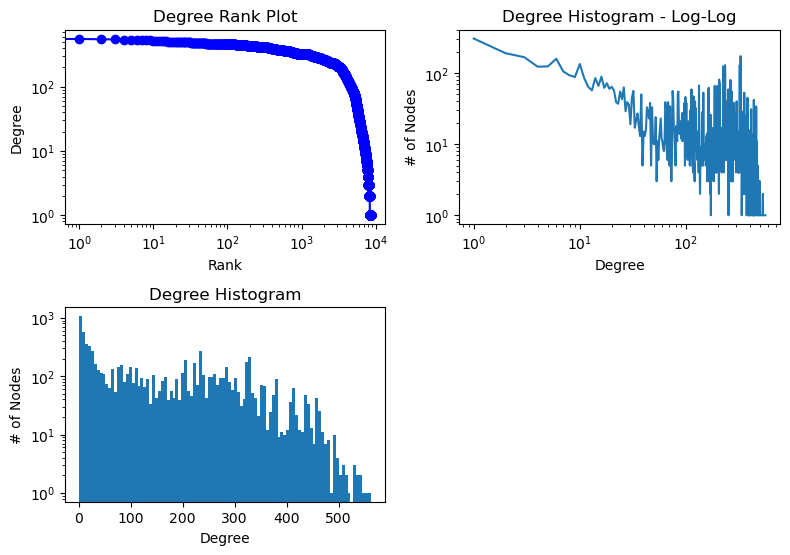

In [8]:
import matplotlib.pyplot as plt

def plot_degree_sequence(degrees):
    fig = plt.figure("Degree Distribution Analysis", figsize=(8, 8))
    axgrid = fig.add_gridspec(3, 2)
    
    # Subplot 1: Degree rank plot
    ax1 = fig.add_subplot(axgrid[0, 0])
    ax1.loglog(degrees, "b-", marker="o")
    ax1.set_title("Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")
    
    # Subplot 2: Degree histogram
    ax2 = fig.add_subplot(axgrid[1, 0])
    ax2.hist(degrees, bins=100, log=True)
    ax2.set_title("Degree Histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")
    
    # Subplot 3: Degree Log Scale
    ax3 = fig.add_subplot(axgrid[0, 1])
    ax3.loglog(*np.unique(degrees, return_counts=True))
    ax3.set_title("Degree Histogram - Log-Log")
    ax3.set_xlabel("Degree")
    ax3.set_ylabel("# of Nodes")
    
    fig.tight_layout()
    plt.show()
plot_degree_sequence(degree_sequence)

## Connected Component Analysis

In [9]:
def giant_network_analysis(G):
    """
    Perform basic analysis on a network graph.
    
    Args:
        G (networkx.Graph): The network graph to analyze
        
    Returns:
        networkx.Graph: The analyzed network graph
    """
    try:
        print(f"\nNetwork Analysis:")

        # Connected components analysis
        num_components = nx.number_connected_components(G)
        print(f"  Number of connected components: {num_components}")
        
        largest_cc = None
        if num_components > 0:
            # Get largest connected component
            largest_cc = max(nx.connected_components(G), key=len)
            largest_cc_size = len(largest_cc)
            print(f"  Size of largest connected component: {largest_cc_size} nodes")
            print(f"  Percentage of nodes in largest component: {largest_cc_size/G.number_of_nodes()*100:.2f}%")
        
        return largest_cc
    
    except Exception as e:
        print(f"Error in analyze_network: {str(e)}")
        raise

# Analyze the network
Giant = giant_network_analysis(G)


Network Analysis:
  Number of connected components: 123
  Size of largest connected component: 8244 nodes
  Percentage of nodes in largest component: 95.53%


In [10]:
import random

g_cc = G.subgraph(Giant).copy()
shortest_path_avg = nx.average_shortest_path_length(g_cc)
print(f"Average shortest path in the giant component: {shortest_path_avg}")
diameter = nx.diameter(g_cc)
print(f"Diameter of the giant component: {diameter}")
# 
# # Finding the APSP is very computation heavy and is infeasible for a graph this large so take an approximation
# 
# # Network diameter
# # Do multiple runs to get a better approximation
# def approximate_diameter(graph, runs=20):
#     diameters = []
#     for i in range(runs):
#         if i%5==0:
#             print(f"Running iteration {i}")
#         diameters.append(nx.algorithms.approximation.diameter(graph))
#     return max(diameters)
# 
# # Network average shortest path
# # Do multiple runs to get a better approximation
# # https://stackoverflow.com/questions/67496060/networkx-average-shortest-path-length-and-diameter-is-taking-forever
# def approximate_average_shortest_path(giant_component, runs=1000):
#     total = 0
#     nodes = list(giant_component.nodes())
#     for i in range(runs):
#         if i%100==0:
#             print(f"Running iteration {i}")
#         u, v = random.sample(nodes, 2) # get two random nodes
#         length = nx.shortest_path_length(giant_component, u, v)
#         total += length
#     return total/runs
# 
# 
# diameter = approximate_diameter(g_cc)
# print(f"Approximate network diameter: {diameter:.4f}")
# 
# shortest_path_avg = approximate_average_shortest_path(g_cc)
# print(f"Network shortest average path: {shortest_path_avg:.4f}")
#         


# 29 minutes

Giant graph made
7.031996919386351
26


In [11]:
# TODO: We can do gephi too. Thoughts?

## Centrality Analysis

In [12]:
# Set up parallelization (use latest nx version, also install nx-parallel)
nx.config.backends.parallel.active = True
nxp_config = nx.config.backends.parallel
nxp_config.n_jobs = 8
nxp_config.verbose = 50

In [ ]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, normalized=True, backend="parallel")
# Take a sample of closeness and discuss the distribution
sample = random.sample(list(G.nodes), 1000)
closeness_centrality = {node: nx.closeness_centrality(G, node) for node in sample} # 2 minutes to run
 

top_5_degree = sorted(degree_centrality.items(),  key=lambda x: x[1], reverse=True)[:5]
top_5_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_5_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 Nodes by Degree Centrality:", top_5_degree)
print("Top 5 Nodes by Betweenness Centrality:", top_5_betweenness)
print("Top 5 Nodes by Closeness Centrality:", top_5_closeness)



# TODO: mean. plot the distribution of closeness, plus other graphs for centrality
# 8 minutes

## Clustering analysis

In [16]:
# Clustering coefficient for each node
clustering_coeffs = nx.clustering(G)

# average clustering coefficient
avg_clustering = nx.average_clustering(G)

# Compute global clustering coefficient
global_clustering = nx.transitivity(G)

# Print results
print(f"Minimum Clustering Coefficient: {min(clustering_coeffs.values())}")
print(f"Maximum Clustering Coefficient: {max(clustering_coeffs.values())}")
print(f"Average Clustering Coefficient: {avg_clustering:.6f}")
print(f"Global Clustering Coefficient: {global_clustering:.6f}")

# 3 minutes

Minimum Clustering Coefficient: -------7654321
Maximum Clustering Coefficient: zygote1212
Average Clustering Coefficient: 0.739996
Global Clustering Coefficient: 0.750133


In [18]:
# Generating Watts-Strogatz small-world network
WS_graph = nx.watts_strogatz_graph(G.number_of_nodes(), round(np.mean(degree_sequence)), 0.1)

# Computing metrics for Watts-Strogatz model
ws_avg_clustering = nx.average_clustering(WS_graph)
ws_global_clustering = nx.transitivity(WS_graph)
ws_avg_shortest_path = nx.average_shortest_path_length(WS_graph)

# Print comparison
print(f"Average Clustering Coefficient Watts-Strogatz: {ws_avg_clustering:.4f}")
print(f"Global Clustering Coefficient Watts-Strogatz: {ws_global_clustering:.4f}")
print(f"Average Shortest Path Length Watts-Strogatz: {ws_avg_shortest_path:.4f}")

# 1 minute

Average Clustering Coefficient Watts-Strogatz: 0.5441
Global Clustering Coefficient Watts-Strogatz: 0.5435
Average Shortest Path Length Watts-Strogatz: 2.5639


## Small World Property Check

In [21]:
print(f"Network shortest average path: {shortest_path_avg:.4f}")
print(f"Average Clustering Coefficient: {avg_clustering:.6f}")
print(f"Global Clustering Coefficient: {global_clustering:.6f}")

print(f"Average Clustering Coefficient Watts-Strogatz: {ws_avg_clustering:.4f}")
print(f"Global Clustering Coefficient Watts-Strogatz: {ws_global_clustering:.4f}")
print(f"Average Shortest Path Length Watts-Strogatz: {ws_avg_shortest_path:.4f}")

Network shortest average path: 7.0320
Average Clustering Coefficient: 0.739996
Global Clustering Coefficient: 0.750133
Average Clustering Coefficient Watts-Strogatz: 0.5441
Global Clustering Coefficient Watts-Strogatz: 0.5435
Average Shortest Path Length Watts-Strogatz: 2.5639


## Modularity Analysis

In [24]:
import community #python-louvain
dendrogram = community.generate_dendrogram(G, random_state = RANDOM_STATE)

for level in range(len(dendrogram)):
    partition = community.partition_at_level(dendrogram, level)
    modularity = community.modularity(partition, G)
    
    print(f"Level {level}: Modularity = {modularity}, Number of Partitions = {len(set(partition.values()))}")

Level 0: Modularity = 0.7727170407231756, Number of Partitions = 377
Level 1: Modularity = 0.8163240483810391, Number of Partitions = 170
Level 2: Modularity = 0.8163649391736344, Number of Partitions = 162
